In [1]:
import ast
import albumentations as A
import numpy as np
import pandas as pd
import json
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from pathlib import Path
from PIL import Image, ImageDraw
from pycocotools import mask as coco_mask


from src.dataset import HierTextDataset, HierTextDataModule

/home/bigdata/anhnn/text-segment/custom-semantic-segment/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_dir = "/home/bigdata/anhnn/text-segment/dataset/hiertext/validation"
label_path = "data/validation.csv"
image_size = 640
device = torch.device("cuda:0")
transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        max_pixel_value=255.0,
    ),
    A.pytorch.ToTensorV2(transpose_mask=True),
])
ds = HierTextDataset(
    image_dir=image_dir,
    label_path=label_path,
    transform=transform
)
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
).to(device)
weights = torch.load("best.pth", map_location=device)
model.load_state_dict(weights)

<All keys matched successfully>

In [3]:
def visualize_mask(image_, mask, color=(255, 0, 0)):
    image = image_.copy()
    draw = ImageDraw.Draw(image, "RGBA")
    draw.bitmap((0,0), Image.fromarray(mask * 127, mode="L"), fill=color)
    return image

def visualize_polygon(image_, polygons, color=(255, 0, 0), alpha=0.5):
    image = image_.copy()
    draw = ImageDraw.Draw(image, "RGBA")
    for polygon in polygons:
        polygon = [(x[0], x[1]) for x in polygon]
        draw.polygon(polygon, fill=color + (int(alpha * 255),))
    return image

def plot_prediction(image_dir, sample, mask_pred):
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    cols = ["Paragraph", "Line", "Word"]
    rows = ["Groundtruth", "Predict"]
    image = Image.open(str(Path(image_dir) / "{}.jpg".format(sample["image_id"])))
    w, h = image.size
    resize = A.Resize(height=h, width=w)
    mask_gt = sample["mask"].numpy()
    mask_pred = mask_pred.numpy()
    fig, axes = plt.subplots(len(rows), len(cols), figsize=(15, 10))
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row)
    for i in range(len(cols)):
        visualized_gt = visualize_mask(image, resize(image=mask_gt[i])["image"], color=colors[i])
        visualized_pred = visualize_mask(image, resize(image=mask_pred[i])["image"], color=colors[i])
        axes[0, i].imshow(np.asarray(visualized_gt))
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[1, i].imshow(np.asarray(visualized_pred))
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    plt.tight_layout()
    plt.show()

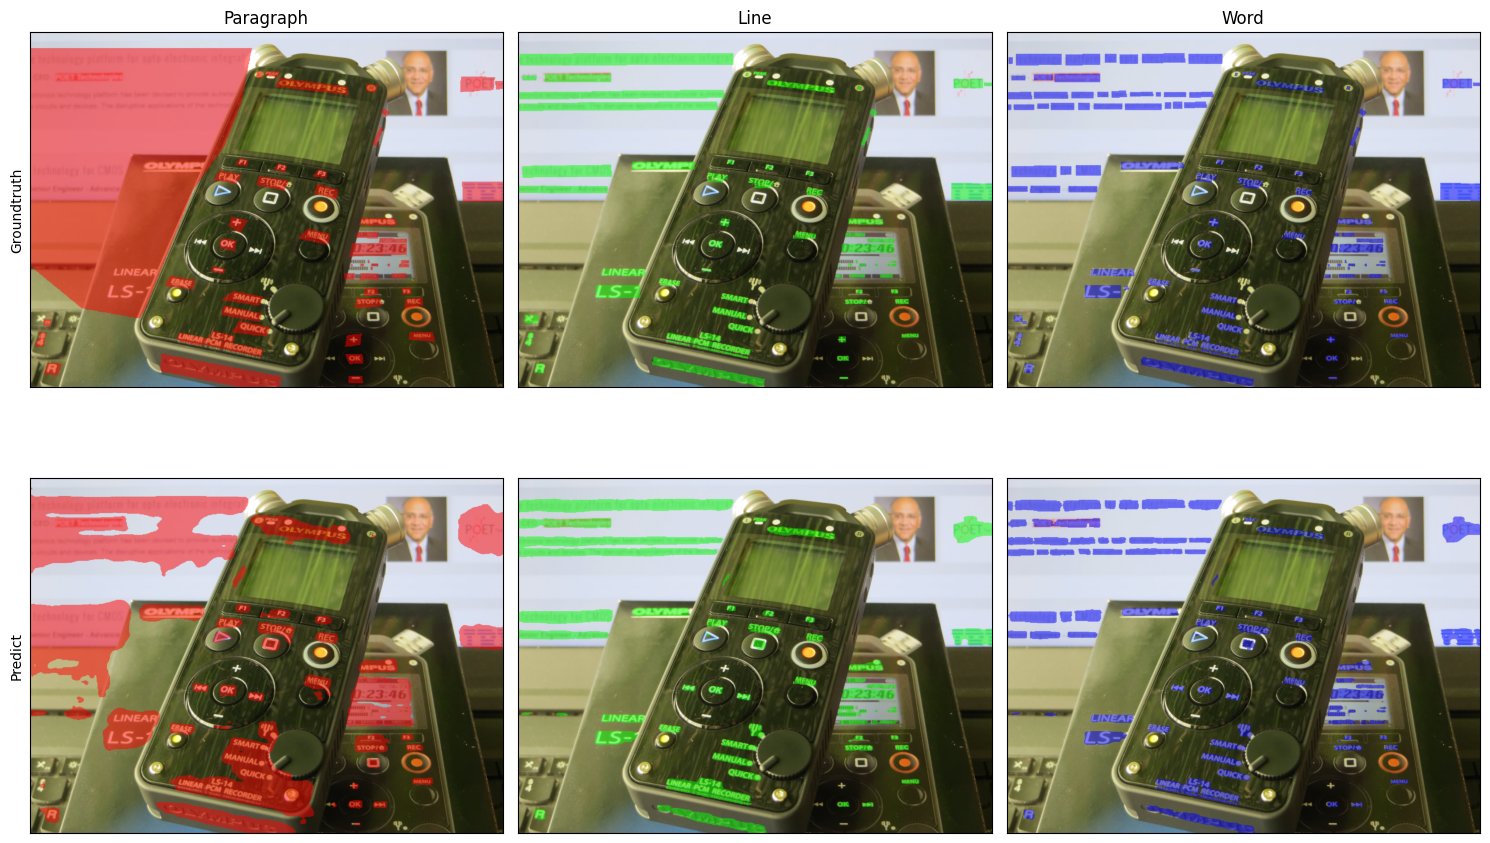

In [11]:
sample = ds[0]
image = sample['image'].to(device)
mask_gt = sample['mask'].to(device)

with torch.no_grad():
    outputs = model(image.unsqueeze(0))
    mask_prob = torch.sigmoid(outputs.squeeze(0))
    mask_pred = (mask_prob > 0.5).cpu().byte()

plot_prediction(image_dir, sample, mask_pred)